# SARIMAX (seasonal autoregressive integrated moving average with exogenous regressors) Model

## Import data, handle missing values, create a clean dataframe

In [1]:
import pandas as pd
import numpy as np
# import seaborn as sns
from math import floor, sqrt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

ic = pd.read_excel("D:\DS\Mine\Corona\I22-01.xlsx", index_col=0, parse_dates=[0]) # Iran Corona
ic['total_vaccinations_f'] = ic['total_vaccinations'].interpolate(method='linear').fillna(0)
ic['stringency_index_f'] = ic['stringency_index'].fillna(method="ffill")
icf = ic.loc[ : , ['total_cases', 'new_cases', 'new_cases_smoothed',
                   'total_deaths', 'new_deaths', 'new_deaths_smoothed', 'total_vaccinations_f', 'stringency_index_f']]
icf = icf.asfreq(None)
pd.options.display.float_format = '{:,.2f}'.format
# pd.set_option('display.max_rows', 2000)
icf

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_vaccinations_f,stringency_index_f
date,,,,,,,,
2020-02-19,2,2,NaN,2,2,NaN,0.00,0.00
2020-02-20,5,3,NaN,2,0,NaN,0.00,2.78
2020-02-21,18,13,NaN,4,2,NaN,0.00,2.78
2020-02-22,28,10,NaN,5,1,NaN,0.00,11.11
2020-02-23,43,15,NaN,8,3,NaN,0.00,11.11
...,...,...,...,...,...,...,...,...
2021-12-28,6188857,2128,"1,867.86",131474,40,43.86,"116,210,697.00",61.57
2021-12-29,6190762,1905,"1,839.57",131527,53,45.14,"116,210,697.00",61.57
2021-12-30,6192698,1936,"1,840.14",131572,45,44.29,"116,210,697.00",61.57


## Defining constants, spliting train and test

In [2]:
length = icf.shape[0]                #number of records
print(length)

683


In [3]:
train_len = floor(length * 0.85)     #of records are going to be used for training
print('Out of', length, 'samples,', train_len, 'samples were devoted to training section and the rest (i.e.',
      length - train_len, 'samples) to test section.')
prl = 28   #4 weeks                                    #prediction lendth: number of days to predict

icn = icf.loc[:,'new_cases']
xd = icn.values
xr = xd[:train_len]
xs = xd[train_len:train_len+prl]
xsp = []

Out of 683 samples, 580 samples were devoted to training section and the rest (i.e. 103 samples) to test section.


## Checking stationarity

In [4]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(xr)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.651971
p-value: 0.082724


p-value > 0.05 so the data is not stationary.

In [5]:
icd = icn.diff(periods=1)[1:] # differencing once
result = adfuller(icd)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.822970
p-value: 0.002681


p-value < 0.05 so the data is stationary when differencing once.

## Models

### Model 1: Auto ARIMA (Seasonal)

In [6]:
# The following line will make it possible to zoom and pan on graphs:
%matplotlib notebook

<IPython.core.display.Javascript object>


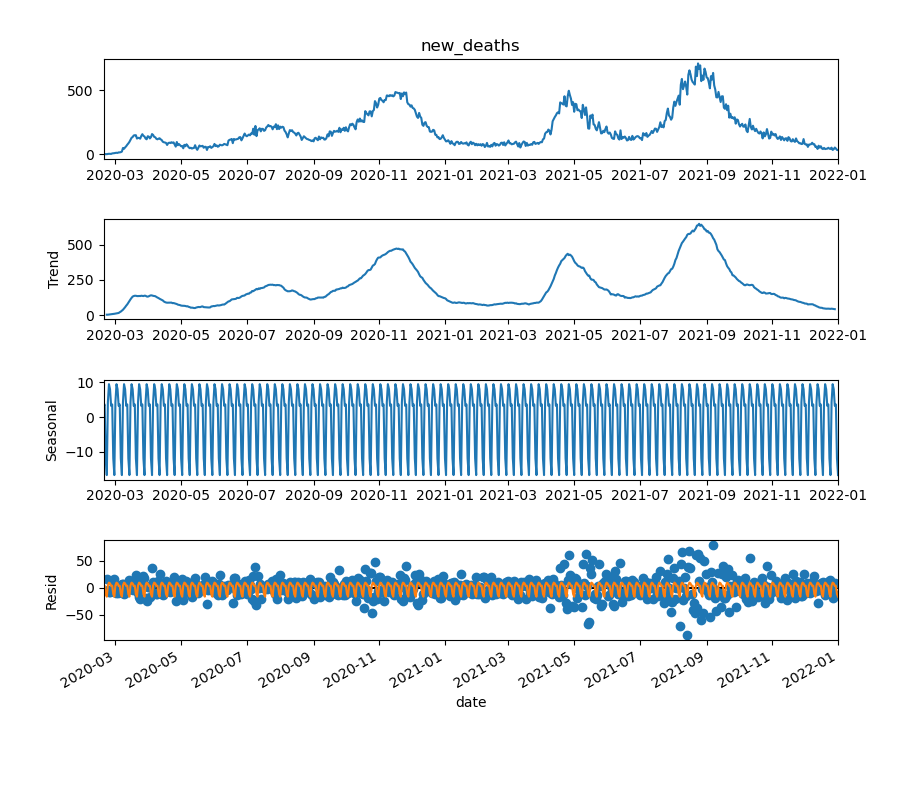

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(icf['new_deaths'])
res.plot();
res.seasonal.plot(figsize=(9, 8));

In [8]:
res.seasonal.head(15)

date
2020-02-19     3.21
2020-02-20     3.61
2020-02-21   -11.83
2020-02-22   -16.65
2020-02-23     4.27
2020-02-24     9.42
2020-02-25     7.96
2020-02-26     3.21
2020-02-27     3.61
2020-02-28   -11.83
2020-02-29   -16.65
2020-03-01     4.27
2020-03-02     9.42
2020-03-03     7.96
2020-03-04     3.21
Freq: D, Name: seasonal, dtype: float64

The seasonality period extracted by seasonal_decompose is 7 days.

In [9]:
seasonality_period = 7
weeks_per_year = 365 // seasonality_period  #Floor division
print('There are approximately', weeks_per_year, 'weeks per year.')

There are approximately 52 weeks per year.


In [90]:
# pip install pmdarima # if you don't have pmdarima

In [10]:
from pmdarima import auto_arima
auto_arima(xr, m=weeks_per_year, trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=10414.924, Time=5.52 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=10496.114, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=10489.808, Time=0.73 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=10491.879, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=10494.235, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[52] intercept   : AIC=10424.381, Time=5.65 sec
 ARIMA(2,1,2)(1,0,0)[52] intercept   : AIC=10421.926, Time=3.85 sec
 ARIMA(2,1,2)(2,0,1)[52] intercept   : AIC=inf, Time=35.66 sec
 ARIMA(2,1,2)(1,0,2)[52] intercept   : AIC=inf, Time=31.31 sec
 ARIMA(2,1,2)(0,0,0)[52] intercept   : AIC=10436.136, Time=0.56 sec
 ARIMA(2,1,2)(0,0,2)[52] intercept   : AIC=10305.997, Time=31.07 sec
 ARIMA(1,1,2)(0,0,2)[52] intercept   : AIC=10422.351, Time=16.48 sec
 ARIMA(2,1,1)(0,0,2)[52] intercept   : AIC=10415.030, Time=7.84 sec
 ARIMA(3,1,2)(0,0,2)[52] intercept   : AIC=10272.967, Time=25.98 sec
 ARIMA(3,1,2

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  580
Model:               SARIMAX(5, 1, 4)   Log Likelihood               -5083.376
Date:                Mon, 10 Jan 2022   AIC                          10186.753
Time:                        12:14:33   BIC                          10230.366
Sample:                             0   HQIC                         10203.758
                                - 580                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3951      0.031     12.740      0.000       0.334       0.456
ar.L2         -1.1100      0.028    -39.922      0.000      -1.165      -1.056
ar.L3          0.2167      0.047      4.615      0.000       0.125       0.309
ar.L4         -0.6832      0.025    -27.266      0.000      -0.732      -0.634
ar.L5         -0.3891      0.027    -14.547      0.000      -0.442      -0.337
ma.L1         -0.6901      0.030    -23.189      0.000      -0.748      -0.632
ma.L2          1.2057      0.032     37.316      0.000       1.142       1.269
ma.L3         -0.6872      0.037    -18.490      0.000      -0.760      -0.614
ma.L4          0.7791      0.032     24.071      0.000       0.716       0.843
sigma2      3.308e+06   8.99e-09   3.68e+14      0.000    3.31e+06    3.31e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):              2825.95
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):             142.05   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.98e+30. Standard errors may be unstable.
"""

Auto ARIMA found the following parameters as the best model:
SARIMAX(5, 1, 4)x(0, 0, 0, 52)

In [57]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
enforce_stationary=False

sm = SARIMAX(xr, order=(5, 1, 4), seasonal_order=(0, 0, 0, 52))
sm_fit = sm.fit()
sm_fit = sm.fit(maxiter=500)
auto_arima_pr = sm_fit.predict(start=train_len, end=train_len+prl-1)
auto_arima_pr_df = pd.DataFrame(auto_arima_pr, index=icn.iloc[train_len:train_len+prl].index, columns=['Auto ARIMA'])

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Model 2: ARIMA (using the best parameters found in the previous study of ARIMA)

In [58]:
from statsmodels.tsa.arima.model import ARIMA
sm = ARIMA(xr, order=(8, 2, 0))
sm_fit = sm.fit()
arima_pr = sm_fit.predict(start=train_len, end=train_len+prl-1)
arima_pr_df = pd.DataFrame(arima_pr, index=icn.iloc[train_len:train_len+prl].index, columns=['Simple ARIMA'])

### Model 3: SARIMAX (using vaccination and stringency as exogenous data)

#### Estimation of exogenous data:

In [13]:
from scipy.optimize import curve_fit
vac_pr_days = 30    #number of days to be used for curve fitting prior to the test date 

def func(x, a, b, c, d, e):
#     return a * x ** 4 + b * x ** 3 + c * x ** 2 + d * x + e
#     return a * x ** 3 + b * x ** 2 + c * x + d
    return a * x ** 2 + b * x + c
#     return a * x + b

xdata = list(range(vac_pr_days))
ydata = icf.iloc[train_len - vac_pr_days:train_len, 6].values

popt = curve_fit(func, xdata, ydata)[0]
y_hat = [func(x, popt[0], popt[1], popt[2], popt[3], popt[4]) for x in range(vac_pr_days, vac_pr_days + prl)]

ydata_test = icf.iloc[train_len:train_len + prl, 6].values
print('MAE:  Mean Absolute Error =           ', "{:2.2f}".format(mean_absolute_error(ydata_test, y_hat)))
print('MAPE: Mean Absolute Percentage Error =', "{:2.1%}".format(mean_absolute_percentage_error(ydata_test, y_hat)))
print('RMSE: Root Mean Squared Error =       ', "{:2.2f}".format(sqrt(mean_squared_error(ydata_test, y_hat))))

MAE:  Mean Absolute Error =            5620601.90
MAPE: Mean Absolute Percentage Error = 8.6%
RMSE: Root Mean Squared Error =        7210436.25


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Considering the error metrics, the model looks a reasonable estimation of vaccination. The warning is due to having 2 extra parameters for curve fitting function (func). It's for more flexibility in changing the model to linear, quadratic, cubic or power 4.

Assigning values to test section for vaccination and stringency:
    vaccination: predicted values
    stringency: we assume the same last value continues 

In [14]:
icf['total_vaccination_pr'] = np.zeros(length)
for x in range(train_len,train_len+prl):
    icf.iloc[x, 8] = y_hat[x - train_len]
icf['stringency_index_pr'] = np.zeros(length)
icf.iloc[train_len:train_len+prl, 9] = icf.iloc[train_len, 7]
icf.iloc[train_len:train_len+prl, 6:10]
# Comparing the actual values and predictions:

,total_vaccinations_f,stringency_index_f,total_vaccination_pr,stringency_index_pr
date,,,,
2021-09-21,"44,597,771.86",74.54,"45,048,695.84",74.54
2021-09-22,"45,823,273.71",74.54,"46,256,042.54",74.54
2021-09-23,"47,048,775.57",74.54,"47,493,564.25",74.54
2021-09-24,"48,274,277.43",74.54,"48,761,260.97",74.54
2021-09-25,"49,499,779.29",74.54,"50,059,132.69",74.54
2021-09-26,"50,725,281.14",74.54,"51,387,179.42",74.54
2021-09-27,"51,950,783.00",74.54,"52,745,401.15",74.54
2021-09-28,"52,905,075.83",74.54,"54,133,797.88",74.54
2021-09-29,"53,859,368.67",74.54,"55,552,369.63",74.54


In [60]:
# Column 6: total_vaccinations_f
# Column 7: stringency_index_f
sm = SARIMAX(xr, order=(5, 1, 4), seasonal_order=(0, 0, 0, 52), exog=icf.iloc[:train_len, 6:8]) 
enforce_stationary=False
enforce_invertibility=False
sm.k_exog = 2
sm_fit = sm.fit(maxiter=500)
srx_pr_df = sm_fit.predict(start=train_len, end=train_len+prl-1, exog=icf.iloc[train_len:train_len + prl, 8:10])
sm_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  580
Model:               SARIMAX(5, 1, 4)   Log Likelihood               -5086.674
Date:                Mon, 10 Jan 2022   AIC                          10197.347
Time:                        17:38:01   BIC                          10249.683
Sample:                    02-19-2020   HQIC                         10217.753
                         - 09-20-2021                                         
Covariance Type:                  opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
total_vaccinations_f    -0.0004      0.000     -2.817      0.005      -0.001      -0.000
stringency_index_f     -11.2475     92.870     -0.121      0.904    -193.270     170.775
ar.L1                    0.3226      0.054      6.022      0.000       0.218       0.428
ar.L2                   -0.9832      0.051    -19.440      0.000      -1.082      -0.884
ar.L3                    0.0489      0.069      0.704      0.481      -0.087       0.185
ar.L4                   -0.5678      0.035    -16.288      0.000      -0.636      -0.499
ar.L5                   -0.4315      0.033    -12.952      0.000      -0.497      -0.366
ma.L1                   -0.6569      0.055    -11.958      0.000      -0.765      -0.549
ma.L2                    1.0184      0.064     15.977      0.000       0.893       1.143
ma.L3                   -0.4646      0.066     -7.088      0.000      -0.593      -0.336
ma.L4                    0.6148      0.049     12.496      0.000       0.518       0.711
sigma2                3.277e+06      0.002   1.64e+09      0.000    3.28e+06    3.28e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2499.59
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             132.09   Skew:                             0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.37e+25. Standard errors may be unstable.
"""

<IPython.core.display.Javascript object>


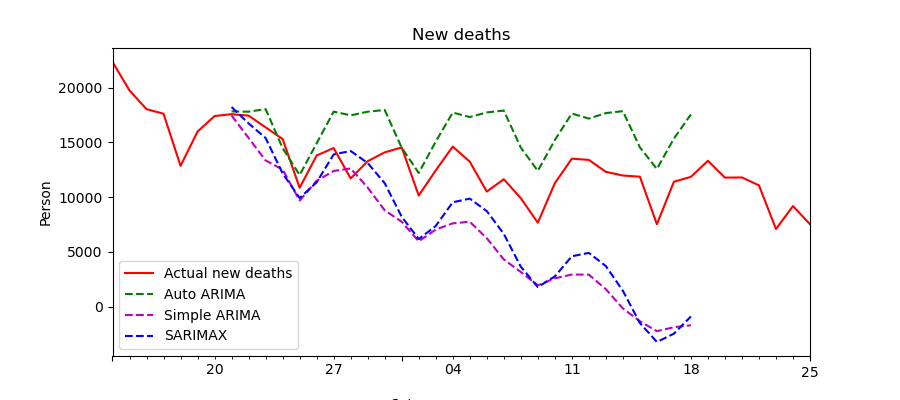

In [61]:
fig, ax = plt.subplots(figsize=(9,4))
ax.set(title='New deaths', xlabel='Date', ylabel='Person')

icf.iloc[train_len-7:train_len+prl + 7,1].plot(ax=ax, style='r', label='Actual new deaths')
auto_arima_pr_df.plot(ax=ax, style='g--', label='Auto ARIMA')
arima_pr_df.plot(ax=ax, style='m--', label='Simple ARIMA')
srx_pr_df.plot(ax=ax, style='b--', label='SARIMAX')

legend = ax.legend(loc='lower left')

In [203]:
icf.iloc[train_len-4:train_len+prl]

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_vaccinations_f,stringency_index_f,total_vaccination_pr,stringency_index_pr
date,,,,,,,,,,
2021-09-17,5396013,17605,"19,585.71",116436,364,436.57,"40,953,736.60",69.91,0.00,0.00
2021-09-18,5408860,12847,"19,041.86",116791,355,423.86,"42,003,863.00",69.91,0.00,0.00
2021-09-19,5424835,15975,"18,435.57",117182,391,410.14,"42,688,066.50",69.91,0.00,0.00
2021-09-20,5442232,17397,"17,700.71",117526,344,395.29,"43,372,270.00",69.91,0.00,0.00
2021-09-21,5459796,17564,"17,020.00",117905,379,391.14,"44,597,771.86",74.54,"45,048,695.84",74.54
2021-09-22,5477229,17433,"16,691.71",118191,286,367.43,"45,823,273.71",74.54,"46,256,042.54",74.54
2021-09-23,5493591,16362,"16,454.71",118508,317,348.00,"47,048,775.57",74.54,"47,493,564.25",74.54
2021-09-24,5508885,15294,"16,124.57",118792,284,336.57,"48,274,277.43",74.54,"48,761,260.97",74.54
2021-09-25,5519728,10843,"15,838.29",119082,290,327.29,"49,499,779.29",74.54,"50,059,132.69",74.54


In [62]:
print('Auto ARIMA')
print('MAE:  Mean Absolute Error =           ', "{:2.2f}".format(mean_absolute_error(xs, auto_arima_pr)))
print('MAPE: Mean Absolute Percentage Error =', "{:2.1%}".format(mean_absolute_percentage_error(xs, auto_arima_pr)))
print('RMSE: Root Mean Squared Error =       ', "{:2.2f}".format(sqrt(mean_squared_error(xs, auto_arima_pr))))

Auto ARIMA
MAE:  Mean Absolute Error =            3501.62
MAPE: Mean Absolute Percentage Error = 30.6%
RMSE: Root Mean Squared Error =        4006.02


In [63]:
print('Simple ARIMA')
print('MAE:  Mean Absolute Error =           ', "{:2.2f}".format(mean_absolute_error(xs, arima_pr)))
print('MAPE: Mean Absolute Percentage Error =', "{:2.1%}".format(mean_absolute_percentage_error(xs, arima_pr)))
print('RMSE: Root Mean Squared Error =       ', "{:2.2f}".format(sqrt(mean_squared_error(xs, arima_pr))))

Simple ARIMA
MAE:  Mean Absolute Error =            6336.48
MAPE: Mean Absolute Percentage Error = 54.1%
RMSE: Root Mean Squared Error =        7505.16


In [64]:
srx_pr = srx_pr_df.values
print('SARIMAX')
print('MAE:  Mean Absolute Error =           ', "{:2.2f}".format(mean_absolute_error(xs, srx_pr)))
print('MAPE: Mean Absolute Percentage Error =', "{:2.1%}".format(mean_absolute_percentage_error(xs, srx_pr)))
print('RMSE: Root Mean Squared Error =       ', "{:2.2f}".format(sqrt(mean_squared_error(xs, srx_pr))))

SARIMAX
MAE:  Mean Absolute Error =            5479.52
MAPE: Mean Absolute Percentage Error = 47.8%
RMSE: Root Mean Squared Error =        6843.94


## Conclusion